In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [13]:
# Load the dataset
df = pd.read_csv("credit_score.csv")

# Display basic info
print(df.info())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Fill missing values (numerical - median, categorical - mode)
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)

for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 87 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CUST_ID                  1000 non-null   object 
 1   INCOME                   1000 non-null   int64  
 2   SAVINGS                  1000 non-null   int64  
 3   DEBT                     1000 non-null   int64  
 4   R_SAVINGS_INCOME         1000 non-null   float64
 5   R_DEBT_INCOME            1000 non-null   float64
 6   R_DEBT_SAVINGS           1000 non-null   float64
 7   T_CLOTHING_12            1000 non-null   int64  
 8   T_CLOTHING_6             1000 non-null   int64  
 9   R_CLOTHING               1000 non-null   float64
 10  R_CLOTHING_INCOME        1000 non-null   float64
 11  R_CLOTHING_SAVINGS       1000 non-null   float64
 12  R_CLOTHING_DEBT          1000 non-null   float64
 13  T_EDUCATION_12           1000 non-null   int64  
 14  T_EDUCATION_6            

C:\Users\USER\AppData\Local\Temp\ipykernel_11704\1485524287.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_11704\1485524287.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [14]:
# Function to detect outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply to key numerical columns
for col in ["INCOME", "SAVINGS", "DEBT"]:
    df = remove_outliers(df, col)


In [15]:
# Convert categorical features to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['CAT_GAMBLING', 'CAT_DEBT', 'CAT_CREDIT_CARD', 'CAT_MORTGAGE', 'CAT_SAVINGS_ACCOUNT', 'CAT_DEPENDENTS'], drop_first=True)


In [16]:
# Debt-to-Income Ratio
df["DTI"] = df["DEBT"] / df["INCOME"]

# Savings-to-Income Ratio
df["STI"] = df["SAVINGS"] / df["INCOME"]

# Credit Utilization Ratio
df["CUR"] = df["DEBT"] / (df["DEBT"] + df["SAVINGS"] + df["INCOME"])

# Total Spending
df["TOTAL_SPENDING"] = df[["T_GROCERIES_12", "T_CLOTHING_12", "T_HOUSING_12", "T_EDUCATION_12", "T_HEALTH_12", "T_TRAVEL_12", "T_ENTERTAINMENT_12", "T_GAMBLING_12", "T_UTILITIES_12", "T_TAX_12", "T_FINES_12"]].sum(axis=1)

# High-Risk Expenditure Percentage
df["GAMBLING_PERCENTAGE"] = df["T_GAMBLING_12"] / df["TOTAL_SPENDING"]

# Flags for High Debt and Low Savings
df["IS_HIGH_DEBT"] = np.where(df["DTI"] > 0.5, 1, 0)
df["IS_LOW_SAVINGS"] = np.where(df["STI"] < 0.2, 1, 0)


In [18]:
from sklearn.preprocessing import MinMaxScaler

# Define important features for credit score calculation
score_features = ["DTI", "STI", "CUR", "TOTAL_SPENDING", "GAMBLING_PERCENTAGE", "IS_HIGH_DEBT", "IS_LOW_SAVINGS"]

# Handle missing values (if any)
df[score_features] = df[score_features].fillna(df[score_features].median())

# Normalize the selected features
scaler = MinMaxScaler()
df[score_features] = scaler.fit_transform(df[score_features])

# Define Weights for Credit Score Calculation
weights = {
    "DTI": -0.35,  # High DTI is bad
    "STI": 0.25,   # High savings is good
    "CUR": -0.30,  # High credit utilization is bad
    "TOTAL_SPENDING": -0.10,  # High spending can be risky
    "GAMBLING_PERCENTAGE": -0.40,  # High gambling is very bad
    "IS_HIGH_DEBT": -0.50,  # High debt means high risk
    "IS_LOW_SAVINGS": -0.30  # Low savings is risky
}

# Compute the Credit Score using a Weighted Sum
df["NEW_CREDIT_SCORE"] = (
    df["DTI"] * weights["DTI"] +
    df["STI"] * weights["STI"] +
    df["CUR"] * weights["CUR"] +
    df["TOTAL_SPENDING"] * weights["TOTAL_SPENDING"] +
    df["GAMBLING_PERCENTAGE"] * weights["GAMBLING_PERCENTAGE"] +
    df["IS_HIGH_DEBT"] * weights["IS_HIGH_DEBT"] +
    df["IS_LOW_SAVINGS"] * weights["IS_LOW_SAVINGS"]
)

# Scale Credit Score to 300 - 850 range
df["NEW_CREDIT_SCORE"] = MinMaxScaler(feature_range=(300, 850)).fit_transform(df[["NEW_CREDIT_SCORE"]])

# Round the scores for better readability
df["NEW_CREDIT_SCORE"] = df["NEW_CREDIT_SCORE"].round(2)


ValueError: Input X contains infinity or a value too large for dtype('float64').

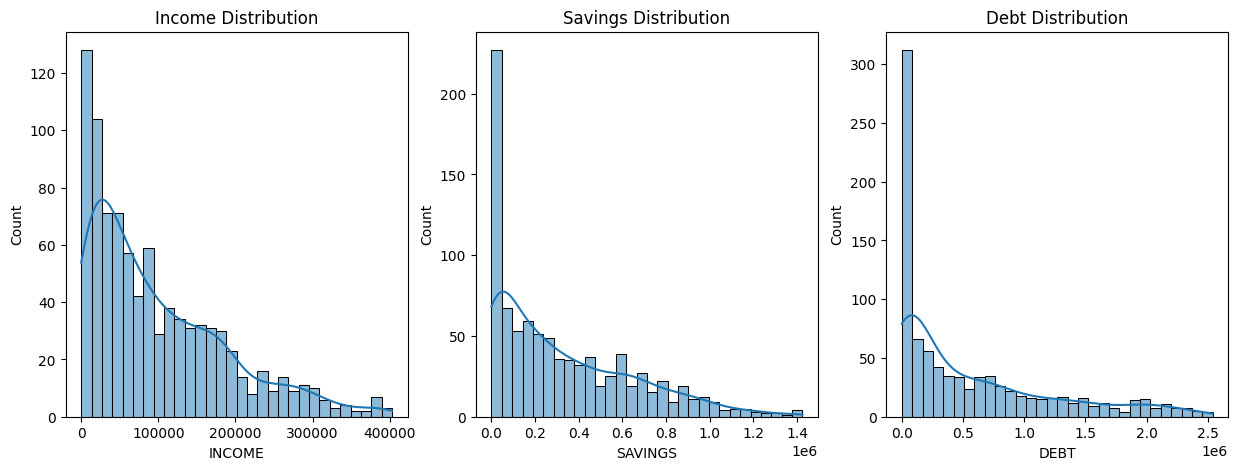

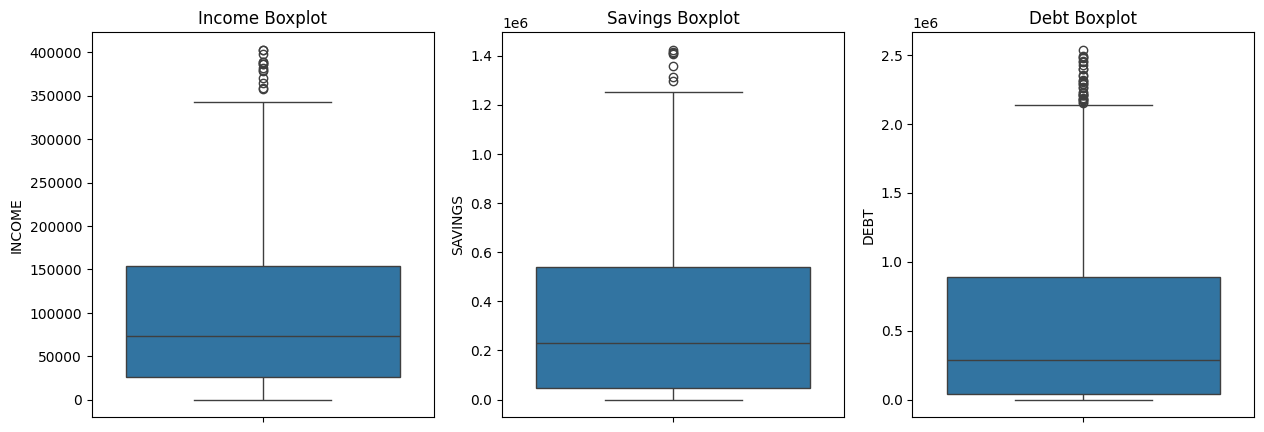

In [ ]:


# Distribution Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(df["INCOME"], bins=30, kde=True, ax=axes[0]).set_title("Income Distribution")
sns.histplot(df["SAVINGS"], bins=30, kde=True, ax=axes[1]).set_title("Savings Distribution")
sns.histplot(df["DEBT"], bins=30, kde=True, ax=axes[2]).set_title("Debt Distribution")
plt.show()

# Boxplots for outlier detection
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y=df["INCOME"], ax=axes[0]).set_title("Income Boxplot")
sns.boxplot(y=df["SAVINGS"], ax=axes[1]).set_title("Savings Boxplot")
sns.boxplot(y=df["DEBT"], ax=axes[2]).set_title("Debt Boxplot")
plt.show()


In [ ]:
df.to_csv("processed_credit_data.csv", index=False)
print("✅ Processed dataset saved successfully!")


✅ Processed dataset saved successfully!
